In [1]:
import numpy as np

import matplotlib.pyplot as plt
import PIL.ImageDraw

from dm_control import mujoco
from dm_control import mjcf
from dm_control.mujoco.wrapper.mjbindings import enums

import os
import sys
module_path = os.path.abspath(os.path.join('./flybody')) # or the path to your source code
# print(module_path)
sys.path.insert(0, module_path)

from flybody.fly_envs import walk_on_ball, flight_imitation_easy
from flybody.utils import display_video
from flybody.tasks.task_utils import retract_wings

from collections import deque

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Create RL environment.
env = flight_imitation_easy()

In [3]:
# Examine RL environment: observations.
env.observation_spec()
# len(env.observation_spec())

OrderedDict([('walker/accelerometer',
              Array(shape=(3,), dtype=dtype('float64'), name='walker/accelerometer')),
             ('walker/actuator_activation',
              Array(shape=(0,), dtype=dtype('float64'), name='walker/actuator_activation')),
             ('walker/gyro',
              Array(shape=(3,), dtype=dtype('float64'), name='walker/gyro')),
             ('walker/joints_pos',
              Array(shape=(25,), dtype=dtype('float64'), name='walker/joints_pos')),
             ('walker/joints_vel',
              Array(shape=(25,), dtype=dtype('float64'), name='walker/joints_vel')),
             ('walker/velocimeter',
              Array(shape=(3,), dtype=dtype('float64'), name='walker/velocimeter')),
             ('walker/world_zaxis',
              Array(shape=(3,), dtype=dtype('float64'), name='walker/world_zaxis'))])

In [4]:
# Examine RL environment: actions.
env.action_spec()

BoundedArray(shape=(12,), dtype=dtype('float64'), name='head_abduct\thead_twist\thead\twing_yaw_left\twing_roll_left\twing_pitch_left\twing_yaw_right\twing_roll_right\twing_pitch_right\tabdomen_abduct\tabdomen\tuser_0', minimum=[-0.2  -3.   -0.5  -1.   -1.   -1.   -1.   -1.   -1.   -0.7  -1.05 -1.  ], maximum=[0.2 3.  0.3 1.  1.  1.  1.  1.  1.  0.7 0.7 1. ])

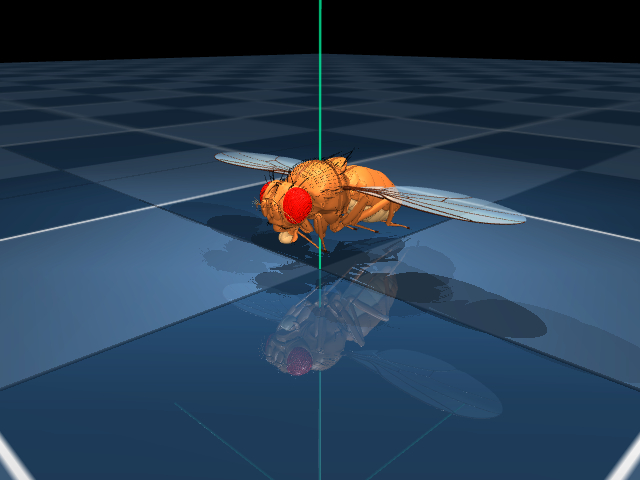

In [5]:
# Reset and visualize the initial state of episode.
timestep = env.reset()

pixels = env.physics.render(camera_id=1, width=640, height=480)
PIL.Image.fromarray(pixels)

In [6]:
# `timestep` contains the current step_type, reward, discount, observation.
timestep

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=OrderedDict([('walker/accelerometer', array([ 3052.22708193, -1942.70996332, -8708.2505976 ])), ('walker/actuator_activation', array([], dtype=float64)), ('walker/gyro', array([0., 0., 0.])), ('walker/joints_pos', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])), ('walker/joints_vel', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])), ('walker/velocimeter', array([0., 0., 0.])), ('walker/world_zaxis', array([0., 0., 1.]))]))

# Run short episode with random actions and make video

In [7]:
timestep = env.reset()
action_size = env.action_spec().shape

frames = []
for i in range(50):
    print(timestep)
    frames.append(env.physics.render(camera_id=1, width=640, height=480))
    # Select random actions. However, normally this line will instead be:
    # action = policy(timestep.observation)
    action = np.random.uniform(-0.3, 0.3, size=action_size)
    timestep = env.step(action)
    
display_video(frames)

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=OrderedDict([('walker/accelerometer', array([ 3052.22708193, -1942.70996332, -8708.2505976 ])), ('walker/actuator_activation', array([], dtype=float64)), ('walker/gyro', array([0., 0., 0.])), ('walker/joints_pos', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])), ('walker/joints_vel', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])), ('walker/velocimeter', array([0., 0., 0.])), ('walker/world_zaxis', array([0., 0., 1.]))]))
TimeStep(step_type=<StepType.MID: 1>, reward=0.12765208609441087, discount=1.0, observation=OrderedDict([('walker/accelerometer', array([  9590.16949797, -13616.62427726, -23083.99426764])), ('walker/actuator_activation', array([], dtype=float64)), ('walker/gyro', array([ 37.55230242, -41.09256093,   1.39388832])), ('walker/joints_pos', array([ 1.28804163e

In [8]:
s_size = 0
for i in env.observation_spec():
    s_size += env.observation_spec()[i].shape[0]
    # print(i)
a_size = action_size[0]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(s_size)
print(a_size)

cpu
62
12


In [9]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size*2)
        self.fc3 = nn.Linear(h_size*2, h_size*2)
        # self.fc4 = nn.Linear(h_size*2, h_size*2)
        self.fc_mean = nn.Linear(h_size*2, a_size)
        self.fc_log_std = nn.Linear(h_size*2, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        mean = self.fc_mean(x)
        log_std = self.fc_log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=10)  # 对log_std进行裁剪
        std = torch.exp(log_std)
        return mean, std

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        mean, std = self.forward(state)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        action_log_prob = dist.log_prob(action).sum(dim=-1)
        return action.cpu().detach().numpy().squeeze(0), action_log_prob

In [10]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=print_every)
    scores = []
    
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        timestep = env.reset()

        saved_log_probs = []
        rewards = []
        none_loss = False
        

        # Line 4 of pseudocode
        for t in range(max_t):
            # data process
            obs = timestep.observation
            obs = np.concatenate([np.ravel(value) for value in obs.values()])

            action, log_prob = policy.act(obs)
            saved_log_probs.append(log_prob)

            timestep = env.step(action)

            if (timestep.reward is None):
                none_loss = True
                break
            rewards.append(timestep.reward)
            # if done:
            #     break
        if none_loss:
            continue
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        
        ## Hence, the queue "returns" will hold the returns in chronological order, from t=0 to t=n_steps
        ## thanks to the appendleft() function which allows to append to the position 0 in constant time O(1)
        ## a normal python list would instead require O(N) to do this.
        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft( gamma*disc_return_t + rewards[t]   )

        ## standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            if np.mean(scores_deque) >= 150.0:
                print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
                break

    return scores

In [ ]:
pixelcopter_hyperparameters = {
    "h_size": 64,
    "n_training_episodes": 2000,
    "n_evaluation_episodes": 10,
    "max_t": 100,
    "gamma": 0.99,
    "lr": 1e-4,
    "state_space": s_size,
    "action_space": a_size,
}

In [12]:
# Create policy and place it to the device
# torch.manual_seed(50)
pixelcopter_policy = Policy(pixelcopter_hyperparameters["state_space"], pixelcopter_hyperparameters["action_space"], pixelcopter_hyperparameters["h_size"]).to(device)
pixelcopter_optimizer = optim.Adam(pixelcopter_policy.parameters(), lr=pixelcopter_hyperparameters["lr"])

In [13]:
scores = reinforce(pixelcopter_policy,
                   pixelcopter_optimizer,
                   pixelcopter_hyperparameters["n_training_episodes"],
                   pixelcopter_hyperparameters["max_t"],
                   pixelcopter_hyperparameters["gamma"],
                   10)

Episode 20	Average Score: 11.23
Episode 30	Average Score: 11.25
Episode 50	Average Score: 11.29
Episode 60	Average Score: 11.32
Episode 90	Average Score: 11.41
Episode 110	Average Score: 11.51
Episode 130	Average Score: 11.47
Episode 140	Average Score: 11.32
Episode 170	Average Score: 11.42
Episode 180	Average Score: 11.39
Episode 200	Average Score: 11.62


In [14]:
timestep = env.reset()
action_size = env.action_spec().shape

frames = []
for i in range(200):
    # print(timestep)
    frames.append(env.physics.render(camera_id=1, width=640, height=480))

    # data process
    obs = timestep.observation
    obs = np.concatenate([np.ravel(value) for value in obs.values()])
    action, _ = pixelcopter_policy.act(obs)
    timestep = env.step(action)
    

display_video(frames)